The main aim of this assignment is use deep learning model classify thee Belgium Traffic Sign based on thier sign like : stop, speed, warning, parking, etc.

Which also includes:
- Dataset laoding with labels
- Performig EDA on dataset
- Definition of model goal and performance measure
- Experiment setup
- Model selection, Model comparison and analysis
- Generating predictions on unseen data

At the end the best model is selected to perform prediction on the unseen data set 

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import regularizers
from PIL import Image


In [2]:
tf.keras.utils.set_random_seed(1)


# DataSet
Dataset consist of Belgium Traffic Signal images which are subdidvided into various category of thier shapes like round, hex etc and than these shapes are further subdivided into type of sign like no parking etc.
In this part we will exploring the data based on thier Sign Types.>
<p>Loading data is dataframe from the system with sub directory as values for shape and sign column along with image name and its corrsponding relative path

In [3]:
path ="./trafficsigns_dataset/"
lst = []
for root, dirs, files in os.walk(path):
    for file in files:
        if(file.endswith(".png")):
#             print(root)
            root1=root.split("/")[-1].split("\\")
            filepath=path+root1[0]+'/'+root1[1]+'/'+file
            lst.append([root1[0], root1[1], file, filepath])
dfdata = pd.DataFrame(lst, columns=['shape', 'sign', 'imageName','filePath'])

# Exporing the data from each Sign Type.
## EDA
We have iterate over the subdirecories to find the amount of data for each shapes/type and number of such shapes/sign type and stored this in dataframe with columns like:
- shape- the shape of the sign that round, hex, diamond etc...
- sign- the type of sign bicycle, noparking, crossing etc..
- imageName - name of the image 
- filePath - the relative path of image.

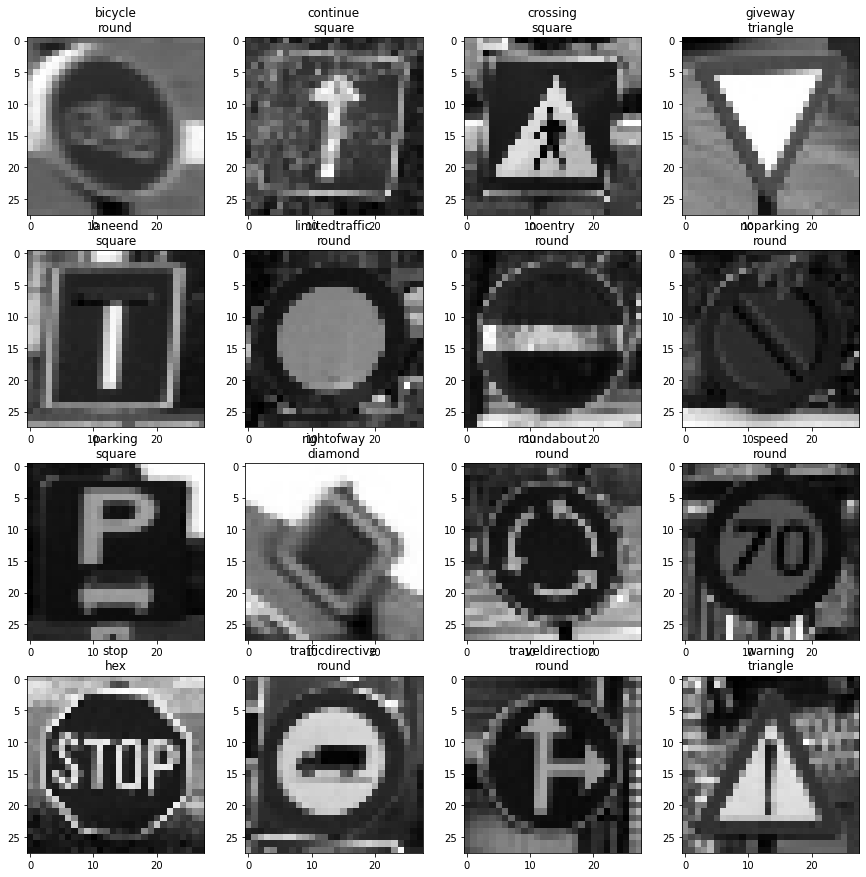

In [4]:
sample_df = dfdata.groupby('sign').apply(lambda x: x.sample(n=1))
fig = plt.figure(figsize=(15, 15))
count=0
for i in sample_df.itertuples():
    im = np.asarray(Image.open(getattr(i,'filePath')))
    fig.add_subplot(4, 4, count+1)
    plt.imshow(im,cmap='gray')
    count+=1
    shape=getattr(i,'shape')
    type_1=getattr(i,'sign')
    plt.title(type_1+'\n'+shape)

As we can see from above random image group by there shape, there are 16 types of sign namely.
- warning             
- noentry             
- speed               
- bicycle             
- rightofway          
- parking             
- noparking           
- giveway             
- continue            
- trafficdirective    
- limitedtraffic      
- traveldirection     
- laneend             
- roundabout           
- crossing             
- stop 

And the images are of 28 * 28 dimensions and its an grayscale image.

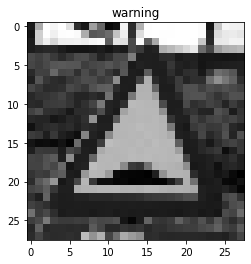

Shape of the image is:: (28, 28)


In [5]:
img = mpimg.imread(filepath)
imgplot = plt.imshow(img,cmap='gray')
shape=getattr(i,'shape')
type_1=getattr(i,'sign')
plt.title(type_1)
plt.show()
print('Shape of the image is::',img.shape)

Checking data distribution in histogram:

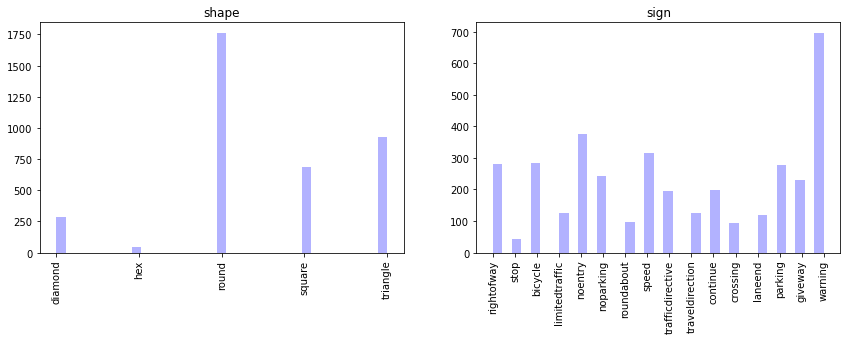

In [6]:
plt.figure(figsize=(30,50))
for i, col in enumerate(['shape', 'sign']):
    plt.subplot(10,4,i+1)
    plt.hist(dfdata[col], alpha=0.3, color='blue',bins=35)
    plt.title(col)
    plt.xticks(rotation='vertical')

#### Observation-

- Significant amount of data imbalance this will required some method like adding weight, re-sampling.
- Higest data in class type warning around 695 plus.
- Lowest data in class type stop less than 43.
- Model can be skewed and bias if train direclty on this data.
- Another significant obersavtion is shape are divided in 16 sub category. Hence its an clasification problem.


<p>Counts for each Sign:</p>

In [7]:
dfdata['sign'].value_counts()

warning             695
noentry             375
speed               316
bicycle             285
rightofway          282
parking             276
noparking           242
giveway             231
continue            199
trafficdirective    195
limitedtraffic      125
traveldirection     124
laneend             118
roundabout           98
crossing             95
stop                 43
Name: sign, dtype: int64

Based on EDA we have decided :
- Go with categorical_crossentropy and categorical_accuracy as its classification problem.
- Use of softmax activation function in last dense layer as there are more than one class.
- Train the image in grayscale color mode.
- Use relu optimization function in hidden layers for faster computing performance.
- Use adam optimizer as it has highest training accuracy.
- Use class imbalance handling method of adding weight so that class with less data gets trained fairly

# Preparing data- Experiment setup

Separating out the file along with sign type in different data frame.
There are total 3699 data for shapes.
<p>Splitting the data in train validation data set in ratio of 80:20</p>

In [8]:
model_2_df=pd.DataFrame()
model_2_df['Path']=dfdata['filePath']
model_2_df['Sign']=dfdata['sign']

In [9]:
model_2_df

Path        Sign
0     ./trafficsigns_dataset/diamond/rightofway/0003...  rightofway
1     ./trafficsigns_dataset/diamond/rightofway/0003...  rightofway
2     ./trafficsigns_dataset/diamond/rightofway/0003...  rightofway
3     ./trafficsigns_dataset/diamond/rightofway/0003...  rightofway
4     ./trafficsigns_dataset/diamond/rightofway/0003...  rightofway
...                                                 ...         ...
3694  ./trafficsigns_dataset/triangle/warning/01947_...     warning
3695  ./trafficsigns_dataset/triangle/warning/01947_...     warning
3696  ./trafficsigns_dataset/triangle/warning/01971_...     warning
3697  ./trafficsigns_dataset/triangle/warning/01971_...     warning
3698  ./trafficsigns_dataset/triangle/warning/01971_...     warning

[3699 rows x 2 columns]

Splitting data randomly in train validation set using  train_test_split.

In [10]:
trainX_2,valX_2,trainY_2,valY_2=train_test_split(model_2_df["Path"],model_2_df["Sign"],test_size=0.2,shuffle=True,random_state=10)

Verifying counts of shapes  and data across train and validation set

In [11]:
print('Shape of the trainX, valX, trainY, valY ::',trainX_2.shape, valX_2.shape, trainY_2.shape, valY_2.shape)

Shape of the trainX, valX, trainY, valY :: (2959,) (740,) (2959,) (740,)


In [12]:
trainY_2
trainY_2.value_counts()

warning             553
noentry             287
speed               257
bicycle             236
parking             230
rightofway          215
giveway             191
noparking           184
continue            165
trafficdirective    152
limitedtraffic      104
traveldirection      98
laneend              97
crossing             81
roundabout           72
stop                 37
Name: Sign, dtype: int64

In [13]:
valY_2.value_counts()

warning             142
noentry              88
rightofway           67
speed                59
noparking            58
bicycle              49
parking              46
trafficdirective     43
giveway              40
continue             34
traveldirection      26
roundabout           26
limitedtraffic       21
laneend              21
crossing             14
stop                  6
Name: Sign, dtype: int64

In [14]:
trainX_2.head(2)

92     ./trafficsigns_dataset/diamond/rightofway/0095...
898    ./trafficsigns_dataset/round/noentry/01057_000...
Name: Path, dtype: object

In [15]:
valX_2.head(2)

1893    ./trafficsigns_dataset/round/trafficdirective/...
658     ./trafficsigns_dataset/round/limitedtraffic/00...
Name: Path, dtype: object

In [16]:
train_df=pd.DataFrame()
train_df["Paths"]=trainX_2
train_df["sign"]=trainY_2
val_df=pd.DataFrame()
val_df["Paths"]=valX_2
val_df["sign"]=valY_2

<AxesSubplot:ylabel='sign'>

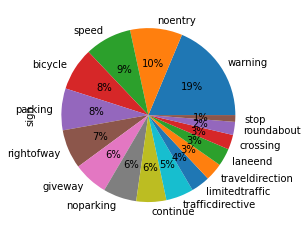

In [63]:
train_df['sign'].value_counts().plot(kind='pie',autopct='%1.f%%')

<AxesSubplot:ylabel='sign'>

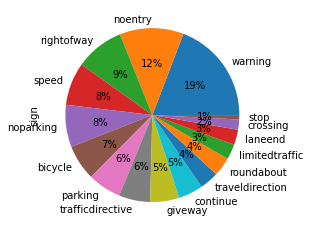

In [64]:
val_df['sign'].value_counts().plot(kind='pie',autopct='%1.f%%')

In [17]:
# len(np.unique(valY))
# len((trainY))
trainX_2,valX_2,trainY_2,valY_2
train_df_type=pd.DataFrame()
train_df_type['Paths'] = trainX_2
train_df_type['Sign'] = trainY_2
print(train_df_type.shape)

val_df_type = pd.DataFrame(columns=['file_path','label'])
val_df_type['Paths'] = valX_2
val_df_type['Sign'] = valY_2

(2959, 2)


# Data Loading for training model

Data is loaded in image generator and image is rescale between 0-1 to bring all the image in same range and save time to process image with high range.
<p>And 'color mode' is set as grayscale and 'class mode' as categorical since its classification problem.</p>
<p>Batch size = 32  standarized batch size.
This also means 32 images from the training dataset will be used to estimate the error gradient before the model weights are updated.</p>

In [18]:
idg_train_types = ImageDataGenerator(rescale=1./255, data_format='channels_last')
idg_val_types = ImageDataGenerator(rescale=1./255, data_format='channels_last')


train_gen_type = idg_train_types.flow_from_dataframe(
      dataframe= train_df_type,
      batch_size=32,
      class_mode='categorical',
      target_size=(28, 28),
      x_col='Paths',
      seed=10,
      y_col='Sign',
      color_mode = 'grayscale')

val_gen_type = idg_val_types.flow_from_dataframe(
        dataframe=val_df_type,
        directory=None,
        x_col="Paths",
        seed=10,
        y_col="Sign",
        target_size=(28, 28),
        batch_size=32,
        class_mode='categorical',
        color_mode = 'grayscale')

Found 2959 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


# Baseline Model
At first Tiny model is setup, here image data is falten and 32 neuron hidden layer with relu activation function is used.
Since in eda we saw there are 16 different type of Sign last output layer is 16 label and activation function is softmax.
<p>Model is trained on 50 epochs and for model compilation following is used:</p>
- optimizer:: 'adam' gives faster computational time and yields better results.<br>
- loss:: 'categorical_crossentropy' since its multi class classification.<br>
- metrics:: 'categorical_accuracy' since its multi class classification.<br>

In [19]:
base_model_type = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16,activation='softmax')
])
base_model_type.summary()
tf.keras.utils.plot_model(base_model_type, show_shapes=True)

base_model_type.compile(optimizer='adam',loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
Total params: 25,648
Trainable params: 25,648
Non-trainable params: 0
_________________________________________________________________


In [20]:

base_model_train = base_model_type.fit(train_gen_type, validation_data = val_gen_type,batch_size=32,epochs=50,shuffle=False)


Epoch 1/50
93/93 [==============================] - 3s 21ms/step - loss: 2.1632 - categorical_accuracy: 0.3981 - val_loss: 1.6191 - val_categorical_accuracy: 0.5905
Epoch 2/50
93/93 [==============================] - 1s 13ms/step - loss: 1.3459 - categorical_accuracy: 0.6789 - val_loss: 1.1306 - val_categorical_accuracy: 0.7527
Epoch 3/50
93/93 [==============================] - 1s 15ms/step - loss: 0.9464 - categorical_accuracy: 0.7898 - val_loss: 0.8532 - val_categorical_accuracy: 0.8554
Epoch 4/50
93/93 [==============================] - 1s 16ms/step - loss: 0.7313 - categorical_accuracy: 0.8533 - val_loss: 0.6966 - val_categorical_accuracy: 0.8527
Epoch 5/50
93/93 [==============================] - 1s 13ms/step - loss: 0.6118 - categorical_accuracy: 0.8706 - val_loss: 0.5998 - val_categorical_accuracy: 0.9054
Epoch 6/50
93/93 [==============================] - 1s 14ms/step - loss: 0.5199 - categorical_accuracy: 0.8942 - val_loss: 0.5216 - val_categorical_accuracy: 0.9054
Epoch 7/50

93/93 [==============================] - 1s 14ms/step - loss: 0.0557 - categorical_accuracy: 0.9882 - val_loss: 0.1842 - val_categorical_accuracy: 0.9459


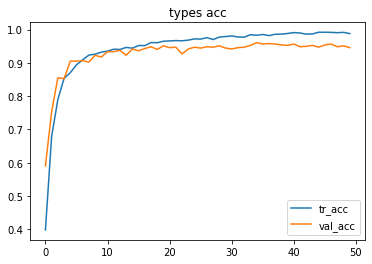

In [21]:
plt.title('types acc')
plt.plot(base_model_train.history['categorical_accuracy'],label='tr_acc')
plt.plot(base_model_train.history['val_categorical_accuracy'],label='val_acc')
plt.legend(loc='best')

### Observation
- Accuracy of training and validation set has increase with number of epochs.
- Loss function is going down with increase in epochs and accuracy of the model is increasing.
- There are epochs where accuracy of validation set is greater than accuracy of the training set at start.
- Accuracy increases steeply till 5 epochs and than accuracy show stable increase

# Handling imbalance 
From the EDA we can see that there is high class imbalance accross the distribution of shapes:
<p>Using the weights of handle these imbalance, weights will increase pentalty of for loss function with class with less data is predicated wrong.<br>Thus ML model will train the class with less data fair chance.

In [22]:
weights = compute_class_weight("balanced",np.unique(train_gen_type.classes),train_gen_type.classes)

C:\Users\aksha\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15], y=[9, 6, 6, 10, 9, 3, 3, 13, 13, 4, 0, 8, 9, 1, 15, 0, 0, 8, 15, 13, 6, 6, 7, 1, 9, 9, 15, 3, 7, 15, 0, 15, 15, 14, 0, 4, 2, 7, 7, 3, 0, 6, 3, 5, 0, 15, 14, 0, 6, 1, 7, 1, 15, 11, 11, 9, 13, 7, 11, 6, 8, 7, 9, 15, 12, 8, 0, 15, 3, 7, 6, 15, 5, 8, 9, 2, 1, 6, 15, 1, 13, 14, 11, 1, 13, 15, 2, 15, 6, 15, 0, 15, 11, 7, 15, 6, 14, 6, 15, 15, 5, 1, 15, 13, 15, 12, 6, 1, 8, 9, 15, 3, 15, 3, 15, 4, 1, 6, 9, 3, 6, 6, 1, 8, 0, 15, 6, 6, 8, 15, 15, 11, 11, 5, 11, 10, 13, 6, 15, 3, 8, 6, 13, 6, 11, 11, 9, 15, 3, 3, 15, 4, 3, 5, 15, 11, 4, 7, 15, 5, 3, 15, 9, 13, 8, 0, 0, 0, 15, 2, 8, 15, 11, 3, 15, 7, 8, 8, 15, 0, 0, 3, 10, 13, 6, 10, 6, 1, 8, 7, 11, 0, 15, 7, 8, 6, 0, 1, 11, 9, 3, 2, 9, 11, 8, 11, 9, 7, 2, 4, 6, 15, 8, 9, 15, 6, 15, 1, 15, 11, 4, 7, 15, 11, 8, 1, 15, 12, 7, 0, 15, 4, 0, 11, 11, 3, 3, 0, 13, 3, 15, 0, 0, 8, 15, 8, 1, 3, 14, 0, 0,

In [23]:
weights_dict={}
for i in range(weights.shape[0]):
    weights_dict[np.unique(train_gen_type.classes)[i]]=weights[i]

In [24]:
weights_dict

{0: 0.7836334745762712,
 1: 1.1208333333333333,
 2: 2.283179012345679,
 3: 0.9682591623036649,
 4: 1.9065721649484537,
 5: 1.7782451923076923,
 6: 0.6443815331010453,
 7: 1.005095108695652,
 8: 0.8040760869565218,
 9: 0.8601744186046512,
 10: 2.568576388888889,
 11: 0.7196011673151751,
 12: 4.9983108108108105,
 13: 1.2166940789473684,
 14: 1.8871173469387754,
 15: 0.3344258589511754}

# training weighted model
### Observations
- Baseline model is kept same.
- Class weight is added while compiling the model.


In [25]:
baseline_model_weighted_type = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16,activation='softmax')
])
baseline_model_weighted_type.summary()
tf.keras.utils.plot_model(baseline_model_weighted_type, show_shapes=True)
baseline_model_weighted_type.compile(optimizer='adam',loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
fitted_baseline_weighted_type=baseline_model_weighted_type.fit(train_gen_type, validation_data = val_gen_type,batch_size=32,epochs=50,class_weight=weights_dict,shuffle=False)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                25120     
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
Total params: 25,648
Trainable params: 25,648
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
93/93 [==============================] - 2s 14ms/step - loss: 2.3985 - categorical_accuracy: 0.2883 - val_loss: 1.9498 - val_categorical_accuracy: 0.5446
Epoch 2/50
93/93 [==============================] - 1s 13ms/step - loss: 1.6565 - categorical_accuracy: 0.6587 - val_loss: 1.3684 - val_categorical_a

93/93 [==============================] - 1s 16ms/step - loss: 0.0866 - categorical_accuracy: 0.9760 - val_loss: 0.2112 - val_categorical_accuracy: 0.9378
Epoch 46/50
93/93 [==============================] - 1s 13ms/step - loss: 0.0846 - categorical_accuracy: 0.9777 - val_loss: 0.2176 - val_categorical_accuracy: 0.9419
Epoch 47/50
93/93 [==============================] - 1s 13ms/step - loss: 0.0785 - categorical_accuracy: 0.9818 - val_loss: 0.2092 - val_categorical_accuracy: 0.9473
Epoch 48/50
93/93 [==============================] - 1s 13ms/step - loss: 0.0786 - categorical_accuracy: 0.9814 - val_loss: 0.2082 - val_categorical_accuracy: 0.9486
Epoch 49/50
93/93 [==============================] - 1s 13ms/step - loss: 0.0784 - categorical_accuracy: 0.9784 - val_loss: 0.2156 - val_categorical_accuracy: 0.9351
Epoch 50/50
93/93 [==============================] - 1s 13ms/step - loss: 0.0736 - categorical_accuracy: 0.9824 - val_loss: 0.2214 - val_categorical_accuracy: 0.9459


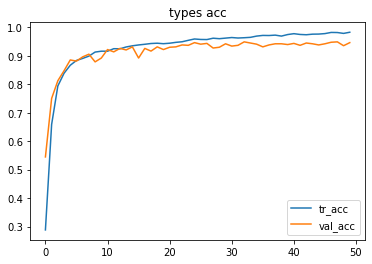

In [26]:
plt.title('types acc')
plt.plot(fitted_baseline_weighted_type.history['categorical_accuracy'],label='tr_acc')
plt.plot(fitted_baseline_weighted_type.history['val_categorical_accuracy'],label='val_acc')
plt.legend(loc='best')

## Observation
- Training model with weight reduce the gap between accuracy and validation graphs.
- Validation graph is smmothen up after few epochs and remain quiet stable.

# Incremental_improvements
In the below code cells model was improved by altering number of layers and number of neurons in each layer expecting a better performance.

In [27]:
baseline_model_weighted_small_type = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16,activation='softmax')
])
baseline_model_weighted_small_type.compile(optimizer='adam',loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
fitted_baseline_weighted_small_type=baseline_model_weighted_small_type.fit(train_gen_type,validation_data=val_gen_type,batch_size=32,epochs=50,class_weight=weights_dict,shuffle=False)

Epoch 1/50
93/93 [==============================] - 2s 14ms/step - loss: 2.3845 - categorical_accuracy: 0.2352 - val_loss: 1.7837 - val_categorical_accuracy: 0.5284
Epoch 2/50
93/93 [==============================] - 1s 13ms/step - loss: 1.4986 - categorical_accuracy: 0.5853 - val_loss: 1.2103 - val_categorical_accuracy: 0.7270
Epoch 3/50
93/93 [==============================] - 1s 13ms/step - loss: 1.0013 - categorical_accuracy: 0.7560 - val_loss: 0.8668 - val_categorical_accuracy: 0.8095
Epoch 4/50
93/93 [==============================] - 1s 15ms/step - loss: 0.7507 - categorical_accuracy: 0.8270 - val_loss: 0.6682 - val_categorical_accuracy: 0.8649
Epoch 5/50
93/93 [==============================] - 2s 18ms/step - loss: 0.6117 - categorical_accuracy: 0.8520 - val_loss: 0.6141 - val_categorical_accuracy: 0.8622
Epoch 6/50
93/93 [==============================] - 2s 16ms/step - loss: 0.4825 - categorical_accuracy: 0.8888 - val_loss: 0.6735 - val_categorical_accuracy: 0.8284
Epoch 7/50

93/93 [==============================] - 1s 13ms/step - loss: 0.0276 - categorical_accuracy: 0.9932 - val_loss: 0.2375 - val_categorical_accuracy: 0.9365


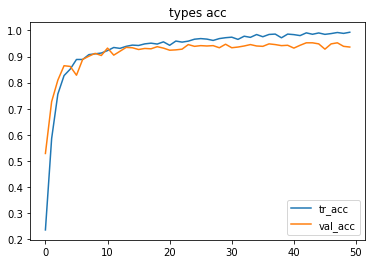

In [28]:
plt.title('types acc')
plt.plot(fitted_baseline_weighted_small_type.history['categorical_accuracy'],label='tr_acc')
plt.plot(fitted_baseline_weighted_small_type.history['val_categorical_accuracy'],label='val_acc')
plt.legend(loc='best')

# Medium model

In [30]:
baseline_model_weighted_Medium_type = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),

    tf.keras.layers.Dense(16,activation='softmax')
])
baseline_model_weighted_Medium_type.compile(optimizer='adam',loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
fitted_baseline_weighted_Medium_type=baseline_model_weighted_Medium_type.fit(train_gen_type,validation_data=val_gen_type,batch_size=32,epochs=50,class_weight=weights_dict,shuffle=False)

Epoch 1/50
93/93 [==============================] - 2s 15ms/step - loss: 2.2652 - categorical_accuracy: 0.3150 - val_loss: 1.5260 - val_categorical_accuracy: 0.5986
Epoch 2/50
93/93 [==============================] - 1s 14ms/step - loss: 1.1538 - categorical_accuracy: 0.6827 - val_loss: 0.8394 - val_categorical_accuracy: 0.8189
Epoch 3/50
93/93 [==============================] - 1s 13ms/step - loss: 0.7337 - categorical_accuracy: 0.8053 - val_loss: 0.6462 - val_categorical_accuracy: 0.8500
Epoch 4/50
93/93 [==============================] - 1s 13ms/step - loss: 0.5381 - categorical_accuracy: 0.8726 - val_loss: 0.6415 - val_categorical_accuracy: 0.8189
Epoch 5/50
93/93 [==============================] - 1s 13ms/step - loss: 0.4224 - categorical_accuracy: 0.8922 - val_loss: 0.4240 - val_categorical_accuracy: 0.9122
Epoch 6/50
93/93 [==============================] - 1s 16ms/step - loss: 0.3488 - categorical_accuracy: 0.9121 - val_loss: 0.4095 - val_categorical_accuracy: 0.8959
Epoch 7/50

93/93 [==============================] - 2s 16ms/step - loss: 0.0151 - categorical_accuracy: 0.9953 - val_loss: 0.1761 - val_categorical_accuracy: 0.9635


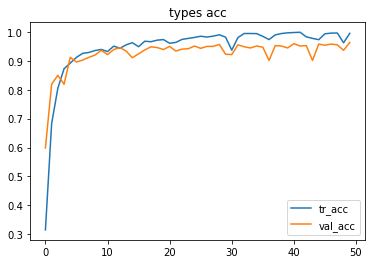

In [31]:
plt.title('types acc')
plt.plot(fitted_baseline_weighted_Medium_type.history['categorical_accuracy'],label='tr_acc')
plt.plot(fitted_baseline_weighted_Medium_type.history['val_categorical_accuracy'],label='val_acc')
plt.legend(loc='best')

# Large Model

In [33]:
baseline_model_weighted_large_type = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),

    tf.keras.layers.Dense(16,activation='softmax')
])
baseline_model_weighted_large_type.compile(optimizer='adam',loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
fitted_baseline_weighted_large_type=baseline_model_weighted_large_type.fit(train_gen_type,validation_data=val_gen_type,batch_size=32,epochs=50,class_weight=weights_dict,shuffle=False)

Epoch 1/50
93/93 [==============================] - 3s 21ms/step - loss: 1.6885 - categorical_accuracy: 0.4812 - val_loss: 0.8222 - val_categorical_accuracy: 0.7473
Epoch 2/50
93/93 [==============================] - 2s 20ms/step - loss: 0.6484 - categorical_accuracy: 0.8003 - val_loss: 0.5253 - val_categorical_accuracy: 0.8595
Epoch 3/50
93/93 [==============================] - 2s 19ms/step - loss: 0.4118 - categorical_accuracy: 0.8716 - val_loss: 0.5122 - val_categorical_accuracy: 0.8392
Epoch 4/50
93/93 [==============================] - 2s 19ms/step - loss: 0.3509 - categorical_accuracy: 0.8878 - val_loss: 0.4115 - val_categorical_accuracy: 0.8946
Epoch 5/50
93/93 [==============================] - 2s 19ms/step - loss: 0.3288 - categorical_accuracy: 0.9020 - val_loss: 0.4973 - val_categorical_accuracy: 0.8649
Epoch 6/50
93/93 [==============================] - 2s 18ms/step - loss: 0.2956 - categorical_accuracy: 0.8973 - val_loss: 0.3934 - val_categorical_accuracy: 0.8811
Epoch 7/50

93/93 [==============================] - 2s 21ms/step - loss: 0.0251 - categorical_accuracy: 0.9926 - val_loss: 0.1337 - val_categorical_accuracy: 0.9649


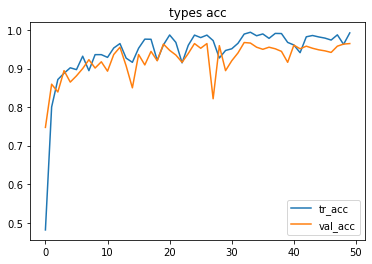

In [34]:
plt.title('types acc')
plt.plot(fitted_baseline_weighted_large_type.history['categorical_accuracy'],label='tr_acc')
plt.plot(fitted_baseline_weighted_large_type.history['val_categorical_accuracy'],label='val_acc')
plt.legend(loc='best')

# Overfitting prevention: Using regularizers

In [36]:
baseline_model_weighted_regularized_type = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

    tf.keras.layers.Dense(16,activation='softmax')
])
baseline_model_weighted_regularized_type.compile(optimizer='adam',loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
baseline_model_weighted_regularized_type=baseline_model_weighted_regularized_type.fit(train_gen_type,validation_data=val_gen_type,batch_size=32,epochs=50,class_weight=weights_dict,shuffle=False)

Epoch 1/50
93/93 [==============================] - 3s 23ms/step - loss: 3.0546 - categorical_accuracy: 0.4684 - val_loss: 1.7304 - val_categorical_accuracy: 0.7851
Epoch 2/50
93/93 [==============================] - 2s 20ms/step - loss: 1.6118 - categorical_accuracy: 0.7966 - val_loss: 1.4933 - val_categorical_accuracy: 0.8203
Epoch 3/50
93/93 [==============================] - 2s 20ms/step - loss: 1.3335 - categorical_accuracy: 0.8371 - val_loss: 1.2043 - val_categorical_accuracy: 0.8919
Epoch 4/50
93/93 [==============================] - 2s 21ms/step - loss: 1.1881 - categorical_accuracy: 0.8641 - val_loss: 1.1322 - val_categorical_accuracy: 0.8703
Epoch 5/50
93/93 [==============================] - 2s 20ms/step - loss: 0.9738 - categorical_accuracy: 0.9054 - val_loss: 1.2626 - val_categorical_accuracy: 0.8108
Epoch 6/50
93/93 [==============================] - 2s 20ms/step - loss: 0.8916 - categorical_accuracy: 0.9118 - val_loss: 0.9404 - val_categorical_accuracy: 0.9068
Epoch 7/50

93/93 [==============================] - 2s 23ms/step - loss: 0.2724 - categorical_accuracy: 0.9679 - val_loss: 0.4003 - val_categorical_accuracy: 0.9311


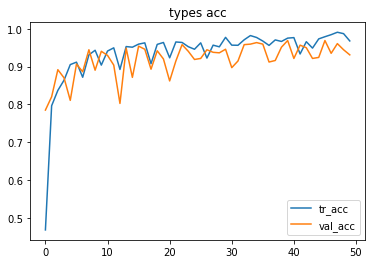

In [37]:
plt.title('types acc')
plt.plot(baseline_model_weighted_regularized_type.history['categorical_accuracy'],label='tr_acc')
plt.plot(baseline_model_weighted_regularized_type.history['val_categorical_accuracy'],label='val_acc')
plt.legend(loc='best')

# Overfitting prevention: Using DropOut

In [39]:
baseline_model_weighted_only_dropOut_type = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(16,activation='softmax')
])
baseline_model_weighted_only_dropOut_type.compile(optimizer='adam',loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
baseline_model_weighted_only_dropOut_type_fitted=baseline_model_weighted_only_dropOut_type.fit(train_gen_type,validation_data=val_gen_type,batch_size=32,epochs=50,class_weight=weights_dict,shuffle=False)

Epoch 1/50
93/93 [==============================] - 3s 23ms/step - loss: 2.8770 - categorical_accuracy: 0.0703 - val_loss: 2.7398 - val_categorical_accuracy: 0.1662
Epoch 2/50
93/93 [==============================] - 2s 23ms/step - loss: 2.6747 - categorical_accuracy: 0.0970 - val_loss: 2.4171 - val_categorical_accuracy: 0.1514
Epoch 3/50
93/93 [==============================] - 2s 25ms/step - loss: 2.2819 - categorical_accuracy: 0.2170 - val_loss: 1.7905 - val_categorical_accuracy: 0.4784
Epoch 4/50
93/93 [==============================] - 2s 26ms/step - loss: 1.9505 - categorical_accuracy: 0.3136 - val_loss: 1.4184 - val_categorical_accuracy: 0.6230
Epoch 5/50
93/93 [==============================] - 2s 22ms/step - loss: 1.7578 - categorical_accuracy: 0.3569 - val_loss: 1.3023 - val_categorical_accuracy: 0.4973
Epoch 6/50
93/93 [==============================] - 2s 20ms/step - loss: 1.6220 - categorical_accuracy: 0.4076 - val_loss: 1.1075 - val_categorical_accuracy: 0.5797
Epoch 7/50

93/93 [==============================] - 2s 25ms/step - loss: 0.7679 - categorical_accuracy: 0.7462 - val_loss: 0.4374 - val_categorical_accuracy: 0.8892


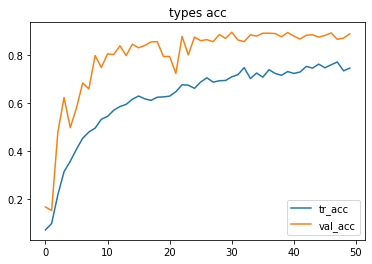

In [40]:
plt.title('types acc')
plt.plot(baseline_model_weighted_only_dropOut_type_fitted.history['categorical_accuracy'],label='tr_acc')
plt.plot(baseline_model_weighted_only_dropOut_type_fitted.history['val_categorical_accuracy'],label='val_acc')
plt.legend(loc='best')

# Overfitting prevention: Using DropOut and regularizers

In [44]:
baseline_model_weighted_dropOut_reg_type = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(16,activation='softmax')
])
baseline_model_weighted_dropOut_reg_type.compile(optimizer='adam',loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
baseline_model_weighted_dropOut_reg_type_fitted=baseline_model_weighted_dropOut_reg_type.fit(train_gen_type,validation_data=val_gen_type,batch_size=32,epochs=50,class_weight=weights_dict,shuffle=False)

Epoch 1/50
93/93 [==============================] - 2s 20ms/step - loss: 4.6628 - categorical_accuracy: 0.0645 - val_loss: 4.3202 - val_categorical_accuracy: 0.0486
Epoch 2/50
93/93 [==============================] - 2s 18ms/step - loss: 4.0153 - categorical_accuracy: 0.1210 - val_loss: 3.6173 - val_categorical_accuracy: 0.2257
Epoch 3/50
93/93 [==============================] - 2s 19ms/step - loss: 3.4319 - categorical_accuracy: 0.2369 - val_loss: 2.8581 - val_categorical_accuracy: 0.2932
Epoch 4/50
93/93 [==============================] - 2s 18ms/step - loss: 2.9639 - categorical_accuracy: 0.3238 - val_loss: 2.3744 - val_categorical_accuracy: 0.5068
Epoch 5/50
93/93 [==============================] - 2s 18ms/step - loss: 2.5923 - categorical_accuracy: 0.4157 - val_loss: 2.0337 - val_categorical_accuracy: 0.5662
Epoch 6/50
93/93 [==============================] - 2s 18ms/step - loss: 2.2819 - categorical_accuracy: 0.4667 - val_loss: 1.6999 - val_categorical_accuracy: 0.7608
Epoch 7/50

93/93 [==============================] - 2s 17ms/step - loss: 0.9904 - categorical_accuracy: 0.7800 - val_loss: 0.7182 - val_categorical_accuracy: 0.9041


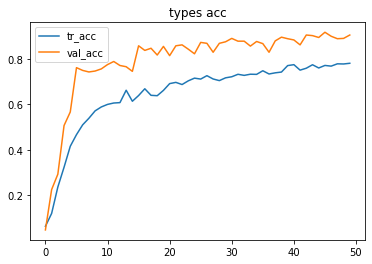

In [45]:
plt.title('types acc')
plt.plot(baseline_model_weighted_dropOut_reg_type_fitted.history['categorical_accuracy'],label='tr_acc')
plt.plot(baseline_model_weighted_dropOut_reg_type_fitted.history['val_categorical_accuracy'],label='val_acc')
plt.legend(loc='best')

Out of all above models, 'baseline_model_weighted_type' is chosen because on observing the accuracy plot its seems that its validation accuaracy is lesser than training accuarcy for most number of epochs.

# Creating image data generators with augmentation

Initializing ImageDataGenerator to make the data(Images), alterable to consider more test cases.
<p>
Following image alteration were considered:<br>
    - zoom_range- To recognize zoomed images which may conatin same shape but of a different size.<br>
    - fill_mode- To higlight image features by extending nearby pixels.</p>
    
    
#### We have't considered horizontal_flip/vertical_flip and rotation_range beacuse it can change the menaing of the signs. <br>For Example : In the real world left can become right and up and can become down due to flipping causing incorrect predictions.

In [48]:
new_idg_train_type=ImageDataGenerator(rescale=1/255.0,
                                 data_format='channels_last',
                                 zoom_range=0.2,
                                 fill_mode='nearest')
new_idg_val_type=ImageDataGenerator(rescale=1/255.0,
                                 data_format='channels_last',
                                 zoom_range=0.2,
                                 fill_mode='nearest')

train_gen_type_new = new_idg_train_type.flow_from_dataframe(
      dataframe= train_df_type,
      batch_size=32,
      class_mode='categorical',
      target_size=(28, 28),
      x_col='Paths',
      seed=10,
      y_col='Sign',
      color_mode = 'grayscale')

val_gen_type_new = new_idg_val_type.flow_from_dataframe(
        dataframe=val_df_type,
        directory=None,
        x_col="Paths",
        seed=10,
        y_col="Sign",
        target_size=(28, 28),
        batch_size=32,
        class_mode='categorical',
        color_mode = 'grayscale')

Found 2959 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


# Using conv2D and maxpooling 
- Conv2D is used to highlight image features such as edges.
- MaxPooling maximum values for each patch (2x2) of the image map.

In [50]:
best_aug_type = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(5,(3,3),activation='relu',input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16,activation='softmax'),
    
])

best_aug_type.compile(optimizer='adam',loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
fitted_best_aug_type=best_aug_type.fit(train_gen_type_new,validation_data=val_gen_type_new,batch_size=32,epochs=50,class_weight=weights_dict,shuffle=False)

Epoch 1/50
93/93 [==============================] - 2s 23ms/step - loss: 2.5459 - categorical_accuracy: 0.2254 - val_loss: 2.1242 - val_categorical_accuracy: 0.4392
Epoch 2/50
93/93 [==============================] - 3s 30ms/step - loss: 1.7249 - categorical_accuracy: 0.5357 - val_loss: 1.4194 - val_categorical_accuracy: 0.6216
Epoch 3/50
93/93 [==============================] - 3s 27ms/step - loss: 1.1730 - categorical_accuracy: 0.6789 - val_loss: 1.3803 - val_categorical_accuracy: 0.5851
Epoch 4/50
93/93 [==============================] - 2s 25ms/step - loss: 0.9553 - categorical_accuracy: 0.7269 - val_loss: 0.9358 - val_categorical_accuracy: 0.7122
Epoch 5/50
93/93 [==============================] - 2s 23ms/step - loss: 0.7915 - categorical_accuracy: 0.7753 - val_loss: 0.8988 - val_categorical_accuracy: 0.7324
Epoch 6/50
93/93 [==============================] - 2s 21ms/step - loss: 0.7170 - categorical_accuracy: 0.7962 - val_loss: 0.7467 - val_categorical_accuracy: 0.7905
Epoch 7/50

93/93 [==============================] - 2s 19ms/step - loss: 0.1206 - categorical_accuracy: 0.9672 - val_loss: 0.4517 - val_categorical_accuracy: 0.8770


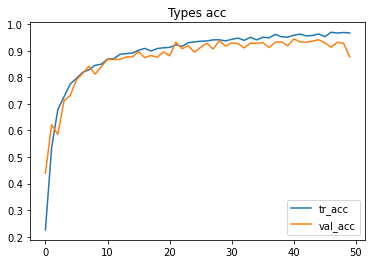

In [51]:
plt.title('Types acc')
plt.plot(fitted_best_aug_type.history['categorical_accuracy'],label='tr_acc')
plt.plot(fitted_best_aug_type.history['val_categorical_accuracy'],label='val_acc')
plt.legend(loc='best')

# Altering Max pooling layers.

In [53]:
best_aug_1_type = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(5,(3,3),activation='relu',input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
     tf.keras.layers.Conv2D(5,(3,3),activation='relu',input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16,activation='softmax'),
    
])
best_aug_1_type.compile(optimizer='adam',loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
best_aug_1_type_fitted=best_aug_1_type.fit(train_gen_type_new,validation_data=val_gen_type_new,batch_size=32,epochs=100,class_weight=weights_dict,shuffle=False)

Epoch 1/100
93/93 [==============================] - 2s 20ms/step - loss: 2.6887 - categorical_accuracy: 0.1335 - val_loss: 2.5208 - val_categorical_accuracy: 0.2595
Epoch 2/100
93/93 [==============================] - 2s 19ms/step - loss: 2.0479 - categorical_accuracy: 0.4062 - val_loss: 1.4901 - val_categorical_accuracy: 0.5703
Epoch 3/100
93/93 [==============================] - 2s 19ms/step - loss: 1.2911 - categorical_accuracy: 0.6009 - val_loss: 1.1376 - val_categorical_accuracy: 0.6743
Epoch 4/100
93/93 [==============================] - 2s 19ms/step - loss: 0.9434 - categorical_accuracy: 0.7131 - val_loss: 0.9403 - val_categorical_accuracy: 0.7500
Epoch 5/100
93/93 [==============================] - 2s 19ms/step - loss: 0.7787 - categorical_accuracy: 0.7783 - val_loss: 0.8732 - val_categorical_accuracy: 0.7514
Epoch 6/100
93/93 [==============================] - 2s 19ms/step - loss: 0.6562 - categorical_accuracy: 0.8084 - val_loss: 0.7078 - val_categorical_accuracy: 0.8378
Epoc

93/93 [==============================] - 2s 23ms/step - loss: 0.0995 - categorical_accuracy: 0.9659 - val_loss: 0.2946 - val_categorical_accuracy: 0.9216
Epoch 51/100
93/93 [==============================] - 2s 24ms/step - loss: 0.1181 - categorical_accuracy: 0.9615 - val_loss: 0.2323 - val_categorical_accuracy: 0.9311
Epoch 52/100
93/93 [==============================] - 2s 22ms/step - loss: 0.1103 - categorical_accuracy: 0.9621 - val_loss: 0.2480 - val_categorical_accuracy: 0.9392
Epoch 53/100
93/93 [==============================] - 2s 20ms/step - loss: 0.1006 - categorical_accuracy: 0.9649 - val_loss: 0.2425 - val_categorical_accuracy: 0.9365
Epoch 54/100
93/93 [==============================] - 2s 21ms/step - loss: 0.0969 - categorical_accuracy: 0.9659 - val_loss: 0.2076 - val_categorical_accuracy: 0.9365
Epoch 55/100
93/93 [==============================] - 2s 24ms/step - loss: 0.0887 - categorical_accuracy: 0.9692 - val_loss: 0.2088 - val_categorical_accuracy: 0.9419
Epoch 56/10

93/93 [==============================] - 2s 20ms/step - loss: 0.0457 - categorical_accuracy: 0.9845 - val_loss: 0.1922 - val_categorical_accuracy: 0.9568
Epoch 100/100
93/93 [==============================] - 2s 22ms/step - loss: 0.0508 - categorical_accuracy: 0.9814 - val_loss: 0.1357 - val_categorical_accuracy: 0.9568


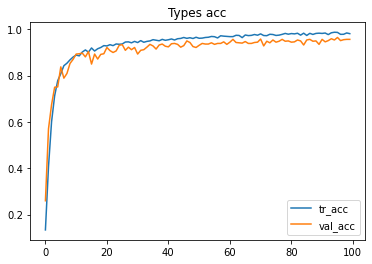

In [54]:
plt.title('Types acc')
plt.plot(best_aug_1_type_fitted.history['categorical_accuracy'],label='tr_acc')
plt.plot(best_aug_1_type_fitted.history['val_categorical_accuracy'],label='val_acc')
plt.legend(loc='best')

In [55]:
# Max pooling layyers added more+more

In [56]:
best_aug_2_type = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(5,(3,3),activation='relu',input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
     tf.keras.layers.Conv2D(10,(3,3),activation='relu',input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Conv2D(15,(3,3),activation='relu',input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16,activation='softmax'),
    
])
best_aug_2_type.compile(optimizer='adam',loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
best_aug_2_type_fit=best_aug_2_type.fit(train_gen_type_new,validation_data=val_gen_type_new,batch_size=32,epochs=100,class_weight=weights_dict,shuffle=False)

Epoch 1/100
93/93 [==============================] - 3s 22ms/step - loss: 2.7603 - categorical_accuracy: 0.0912 - val_loss: 2.7415 - val_categorical_accuracy: 0.1284
Epoch 2/100
93/93 [==============================] - 2s 19ms/step - loss: 2.4904 - categorical_accuracy: 0.2528 - val_loss: 2.1680 - val_categorical_accuracy: 0.2865
Epoch 3/100
93/93 [==============================] - 2s 19ms/step - loss: 1.7675 - categorical_accuracy: 0.4515 - val_loss: 1.5687 - val_categorical_accuracy: 0.5716
Epoch 4/100
93/93 [==============================] - 2s 21ms/step - loss: 1.4035 - categorical_accuracy: 0.5830 - val_loss: 1.5034 - val_categorical_accuracy: 0.5122
Epoch 5/100
93/93 [==============================] - 2s 20ms/step - loss: 1.1324 - categorical_accuracy: 0.6526 - val_loss: 1.3237 - val_categorical_accuracy: 0.5824
Epoch 6/100
93/93 [==============================] - 2s 19ms/step - loss: 1.0302 - categorical_accuracy: 0.6810 - val_loss: 1.0715 - val_categorical_accuracy: 0.6973
Epoc

93/93 [==============================] - 2s 19ms/step - loss: 0.2111 - categorical_accuracy: 0.9358 - val_loss: 0.3024 - val_categorical_accuracy: 0.9095
Epoch 51/100
93/93 [==============================] - 2s 19ms/step - loss: 0.2047 - categorical_accuracy: 0.9388 - val_loss: 0.2803 - val_categorical_accuracy: 0.9189
Epoch 52/100
93/93 [==============================] - 2s 20ms/step - loss: 0.2049 - categorical_accuracy: 0.9398 - val_loss: 0.3002 - val_categorical_accuracy: 0.9135
Epoch 53/100
93/93 [==============================] - 2s 19ms/step - loss: 0.2123 - categorical_accuracy: 0.9311 - val_loss: 0.2345 - val_categorical_accuracy: 0.9270
Epoch 54/100
93/93 [==============================] - 2s 19ms/step - loss: 0.1875 - categorical_accuracy: 0.9442 - val_loss: 0.2948 - val_categorical_accuracy: 0.9095
Epoch 55/100
93/93 [==============================] - 2s 19ms/step - loss: 0.1917 - categorical_accuracy: 0.9392 - val_loss: 0.2697 - val_categorical_accuracy: 0.9176
Epoch 56/10

93/93 [==============================] - 2s 19ms/step - loss: 0.1006 - categorical_accuracy: 0.9676 - val_loss: 0.1957 - val_categorical_accuracy: 0.9473
Epoch 100/100
93/93 [==============================] - 2s 19ms/step - loss: 0.0968 - categorical_accuracy: 0.9655 - val_loss: 0.1499 - val_categorical_accuracy: 0.9581


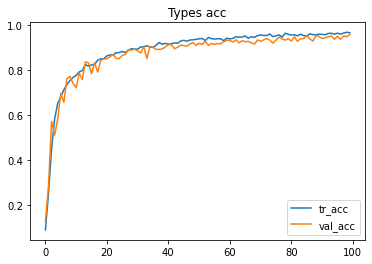

In [57]:
plt.title('Types acc')
plt.plot(best_aug_2_type_fit.history['categorical_accuracy'],label='tr_acc')
plt.plot(best_aug_2_type_fit.history['val_categorical_accuracy'],label='val_acc')
plt.legend(loc='best')

# Final Model
On alteration with maxpooling and Conv2D layers the best model was found to be the one with one maxpooling and conv2D layer each.

# Ultimate Judgement: Testing the best model with new data.

In [58]:
path ="./Final_Testing/"
lst = []
for root, dirs, files in os.walk(path):
    for file in files:
        if(file.endswith(".png")):
#             print(root)
            root1=root.split("/")[-1].split("\\")
            filepath=path+root1[0]+'/'+root1[1]+'/'+file
            lst.append([root1[0], root1[1], file, filepath])
dfdata_test = pd.DataFrame(lst, columns=['shape', 'sign', 'imageName','filePath'])

In [59]:
dfdata_test.head()

shape        sign imageName                                     filePath
0  diamond  rightofway  2415.png  ./Final_Testing/diamond/rightofway/2415.png
1  diamond  rightofway  2416.png  ./Final_Testing/diamond/rightofway/2416.png
2  diamond  rightofway  2417.png  ./Final_Testing/diamond/rightofway/2417.png
3  diamond  rightofway  2418.png  ./Final_Testing/diamond/rightofway/2418.png
4  diamond  rightofway  2419.png  ./Final_Testing/diamond/rightofway/2419.png

In [60]:
new_idg_train_type=ImageDataGenerator(rescale=1/255.0,
                                 data_format='channels_last',
                                 zoom_range=0.2,
                                 fill_mode='nearest')


test_gen_type_new = new_idg_train_type.flow_from_dataframe(
      dataframe= dfdata_test,
      batch_size=1,
      class_mode='categorical',
      target_size=(28, 28),
      x_col='filePath',
      seed=10,
      y_col='sign',
      color_mode = 'grayscale')


Found 1352 validated image filenames belonging to 16 classes.


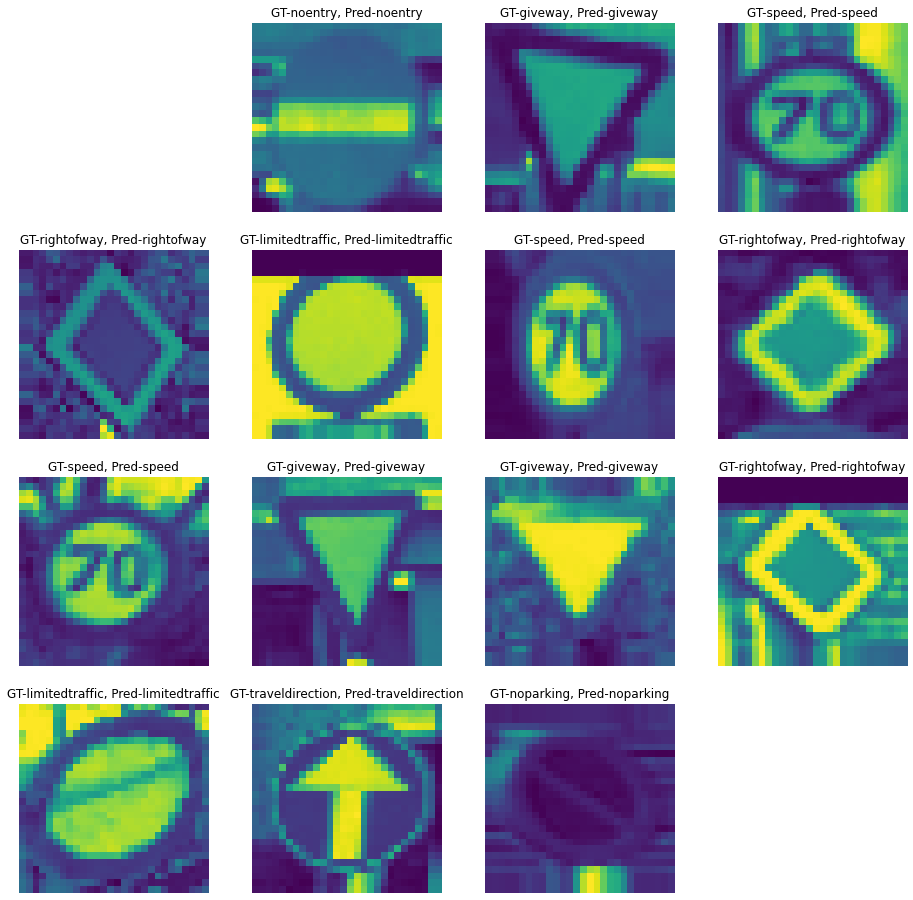

In [61]:

d_inv = {0:'bicycle', 1:'continue', 2:'crossing', 3:'giveway',4:'laneend',
5:'limitedtraffic',6:'noentry',7:'noparking',8:'parking',9:'rightofway',10:'roundabout',
11:'speed',12:'stop',13:'trafficdirective',14:'traveldirection',15:'warning'}
plt.figure(figsize=(16,16))
batches  =1
for x,y in test_gen_type_new:
        batches = batches + 1
        y_hat = best_aug_2_type.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 16:
            plt.subplot(4,4,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

#### GT - actual label<br> Pred - model Prediction

In [62]:
best_aug_2_type.evaluate(test_gen_type_new)

1352/1352 [==============================] - 2s 1ms/step - loss: 0.1806 - categorical_accuracy: 0.9527


[0.18062779307365417, 0.9526627063751221]

##### It is evident that the final model is able to predict on new data accurately as training and validaion data.

# Conclusion and justification:

- The type and size of provided data plays major part in discovery of the final model.<br>
- As mentioned in EDA the data was highly imbalanced and having real image instead of adding weights would be more vaiable option to handle data imabalance.<br>
- Over and Under sampling might be an optionbut increasing 40 images to 400 or reducing 1700 images to 400 would led to data loss or overfitting by training on exacting similar images.<br>
- Also it is observed in real world scenario where the dataset unevenly distributed across its features and data is quiet limited we can use weights concept to balance out the data across the class without need of  physical addition.